In [38]:
#delete contents
shutil.rmtree( "../Tensorflow/content")

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../Tensorflow/content'

In [39]:
import os
import shutil
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

import random

# Constants

In [40]:
FAST_RUN = True
#change for final
epochs = 3 if FAST_RUN else 50
WIDTH=512
HEIGHT=384
IMAGE_SIZE=(WIDTH, HEIGHT)
IMAGE_CHANNELS=3
batch_size = 12
# Dropout rate
d = 0.3

START_EPOCH = 0 
Transfer = False
Pretrained_Link = "../input/pretrained-model/model.h5"

In [41]:
photo_path = "../Tensorflow/UnSortedWaste"
filenames = os.listdir(photo_path)

In [42]:
parent_dir = "../Tensorflow"
path = os.path.join(parent_dir , 'content')
os.mkdir(path)
parent_dir += "/content"

labels = ["cardboard", "glass", "metal", "paper", "plastic", "other"]

for label in labels:
    path = os.path.join(parent_dir , label)
    os.mkdir(path)

In [43]:
labels

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'other']

In [44]:
for filename in filenames:
        category = filename[0:3]
        if category == "car":            
            shutil.copy(photo_path+"/"+filename, parent_dir+"/"+labels[0])
        elif category == "gla":
            shutil.copy(photo_path+"/"+filename, parent_dir+"/"+labels[1])        
        elif category == "met":
            shutil.copy(photo_path+"/"+filename, parent_dir+"/"+labels[2])
        elif category == "pap":
            shutil.copy(photo_path+"/"+filename, parent_dir+"/"+labels[3])
        elif category == "pla":
            shutil.copy(photo_path+"/"+filename, parent_dir+"/"+labels[4])
        else:
            shutil.copy(photo_path+"/"+filename, parent_dir+"/"+labels[5])
        

### Creating a df with path and category for each photo

In [4]:
df = pd.DataFrame({
    'filename': [],
    'category': []
})

for filename in filenames:
        category = filename[0:3]
        if category == "car":
            category1 = "cardboard"
        elif category == "gla":
            category1 = "glass"
        elif category == "met":
            category1 = "metal"
        elif category == "pap":
            category1 = "paper"
        elif category == "pla":
            category1 = "plastic"
        else:
            category1 = "other"
        
        df=df.append({'filename':path +"/"+filename, 'category': category1},ignore_index=True)


### Devide into training testing and visualize

In [5]:
df_train=df.sample(frac=0.8,replace=False)

df_valid=df.drop(df_train.index.values)

paper        469
glass        408
plastic      388
metal        330
cardboard    322
other        105
Name: category, dtype: int64


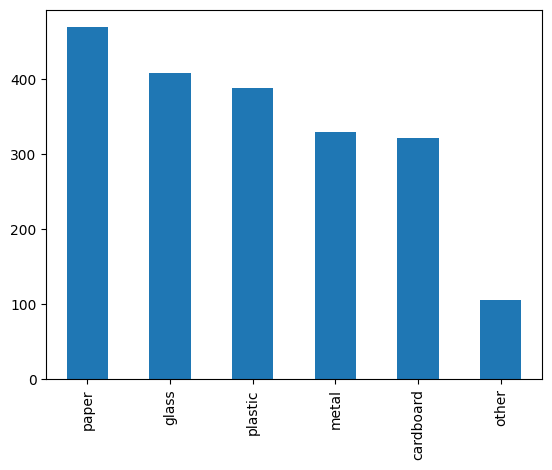

In [6]:
df_train['category'].value_counts().plot.bar()
print (df_train['category'].value_counts())

paper        125
plastic       94
glass         93
cardboard     81
metal         80
other         32
Name: category, dtype: int64


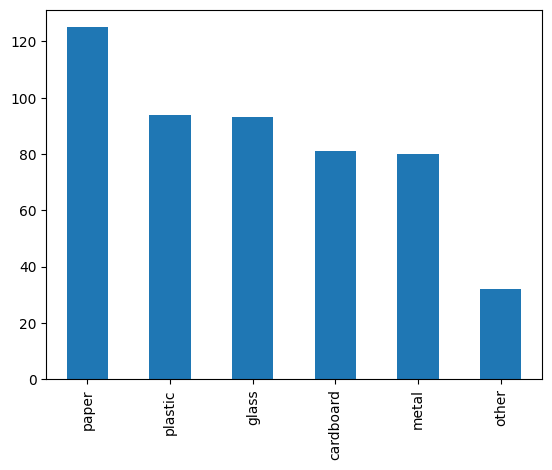

In [7]:
df_valid['category'].value_counts().plot.bar()
print (df_valid['category'].value_counts())

##### the sample of an image from df

metal177.jpg


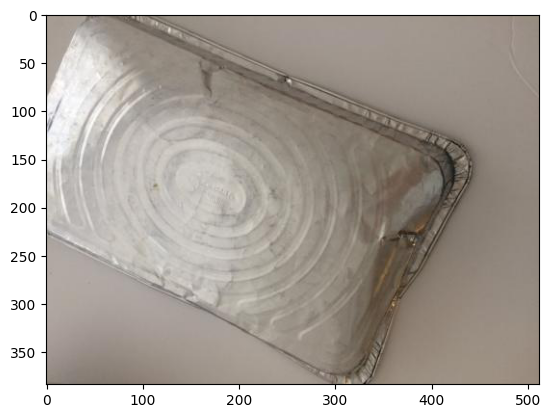

In [44]:
sample = random.choice(filenames)

image = load_img(path + "/"+sample)
plt.imshow(image)
print(sample)

### Building the model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization


model = Sequential([
    #num of filters, 2D шар
        Conv2D(32, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, IMAGE_CHANNELS)),
    
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
    
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
#         Dropout(d),

        Conv2D(128, (3, 3), activation='relu',padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
#         Dropout(d),
    
        Conv2D(256, (3, 3), activation='relu',padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
#         Dropout(d),
    
        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(6, activation='softmax')# 6 because we have 6 classes
])



# if Transfer:
#     model.load_weights(Pretrained_Link)

model.compile(
    # use categorical
    #loss='categorical_crossentropy',
    loss='mean_squared_error',
    optimizer='adam', 
    #metrics=['categorical_accuracy'],
    metrics = ['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 382, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 510, 382, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 191, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 189, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 253, 189, 64)     256       
 hNormalization)                                                 
                                                        

In [46]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [47]:
earlystop = EarlyStopping(patience=10,restore_best_weights=True)

Learning rate schedule: 0.0005 to 0.000442


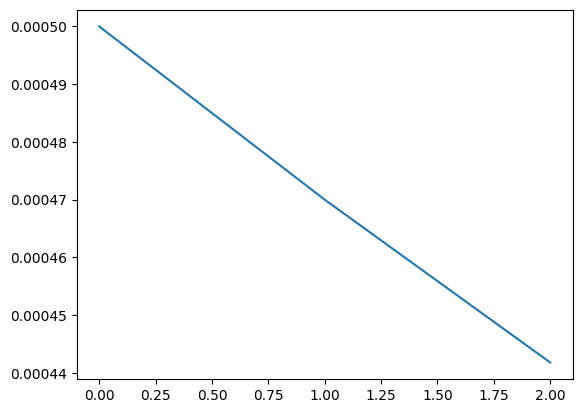

In [48]:
LR_START = 5e-4
LR_MIN = 1e-8
LR_EXP_DECAY = .94

# Define a Learning Rate function on epoch that will decrease exponentially.
def lrfn(epoch):
    lr = (LR_START - LR_MIN) * LR_EXP_DECAY**(epoch+START_EPOCH) + LR_MIN
    return lr
    
lr_callback = LearningRateScheduler(lrfn, verbose=True)

# Visualize the change in learning rate
rng = [i for i in range(START_EPOCH,epochs+START_EPOCH)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g}".format(y[0], y[-1]))

In [49]:
total_train = df_train.shape[0]
total_validate = df_valid.shape[0]

print("Training: {}, Validation: {}".format(total_train,total_validate))

Training: 2022, Validation: 505


In [50]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# According to the dataframe, pull images one by one from image directory
train_generator = train_datagen.flow_from_dataframe(
    df_train, 
    "", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
)

Found 2022 validated image filenames belonging to 6 classes.


In [51]:
validation_datagen = ImageDataGenerator(rescale=1./255)

# According to the dataframe, pull images one by one from image directory
validation_generator = validation_datagen.flow_from_dataframe(
    df_valid, 
    "", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 505 validated image filenames belonging to 6 classes.


In [52]:
history = model.fit(
    # The train generator just tested, can pull training images out from directory.
    train_generator, 
    # Batch size and epochs already set at beginning.
    batch_size=batch_size,
    epochs=epochs,
    # The validation generator, can pull validation images out from directory.
    validation_data=validation_generator,

    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    # Two callback methods: early stopping and learning rate scheduling
    callbacks=[earlystop, lr_callback]
)

# Save Model
model.save_weights("model.h5")


Epoch 1: LearningRateScheduler setting learning rate to 0.0005.
Epoch 1/3
168/168 [==============================] - 582s 3s/step - loss: 0.1605 - accuracy: 0.3026 - val_loss: 0.1624 - val_accuracy: 0.2202 - lr: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0004700005999999999.
Epoch 2/3
168/168 [==============================] - 592s 4s/step - loss: 0.1475 - accuracy: 0.3731 - val_loss: 0.1935 - val_accuracy: 0.2321 - lr: 4.7000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0004418011639999999.
Epoch 3/3
168/168 [==============================] - 552s 3s/step - loss: 0.1335 - accuracy: 0.4199 - val_loss: 0.1226 - val_accuracy: 0.4623 - lr: 4.4180e-04


In [21]:
test_df = df.sample(frac = 0.3)
# Number of testing samples
nb_samples = test_df.shape[0]

In [22]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 758 validated image filenames.


In [23]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\Sofiia\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [24]:
test_df['pred_category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['pred_category'] = test_df['pred_category'].replace(label_map)

<AxesSubplot:>

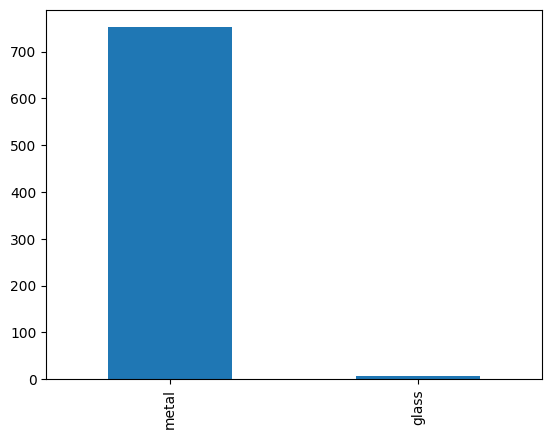

In [25]:
test_df['pred_category'].value_counts().plot.bar()

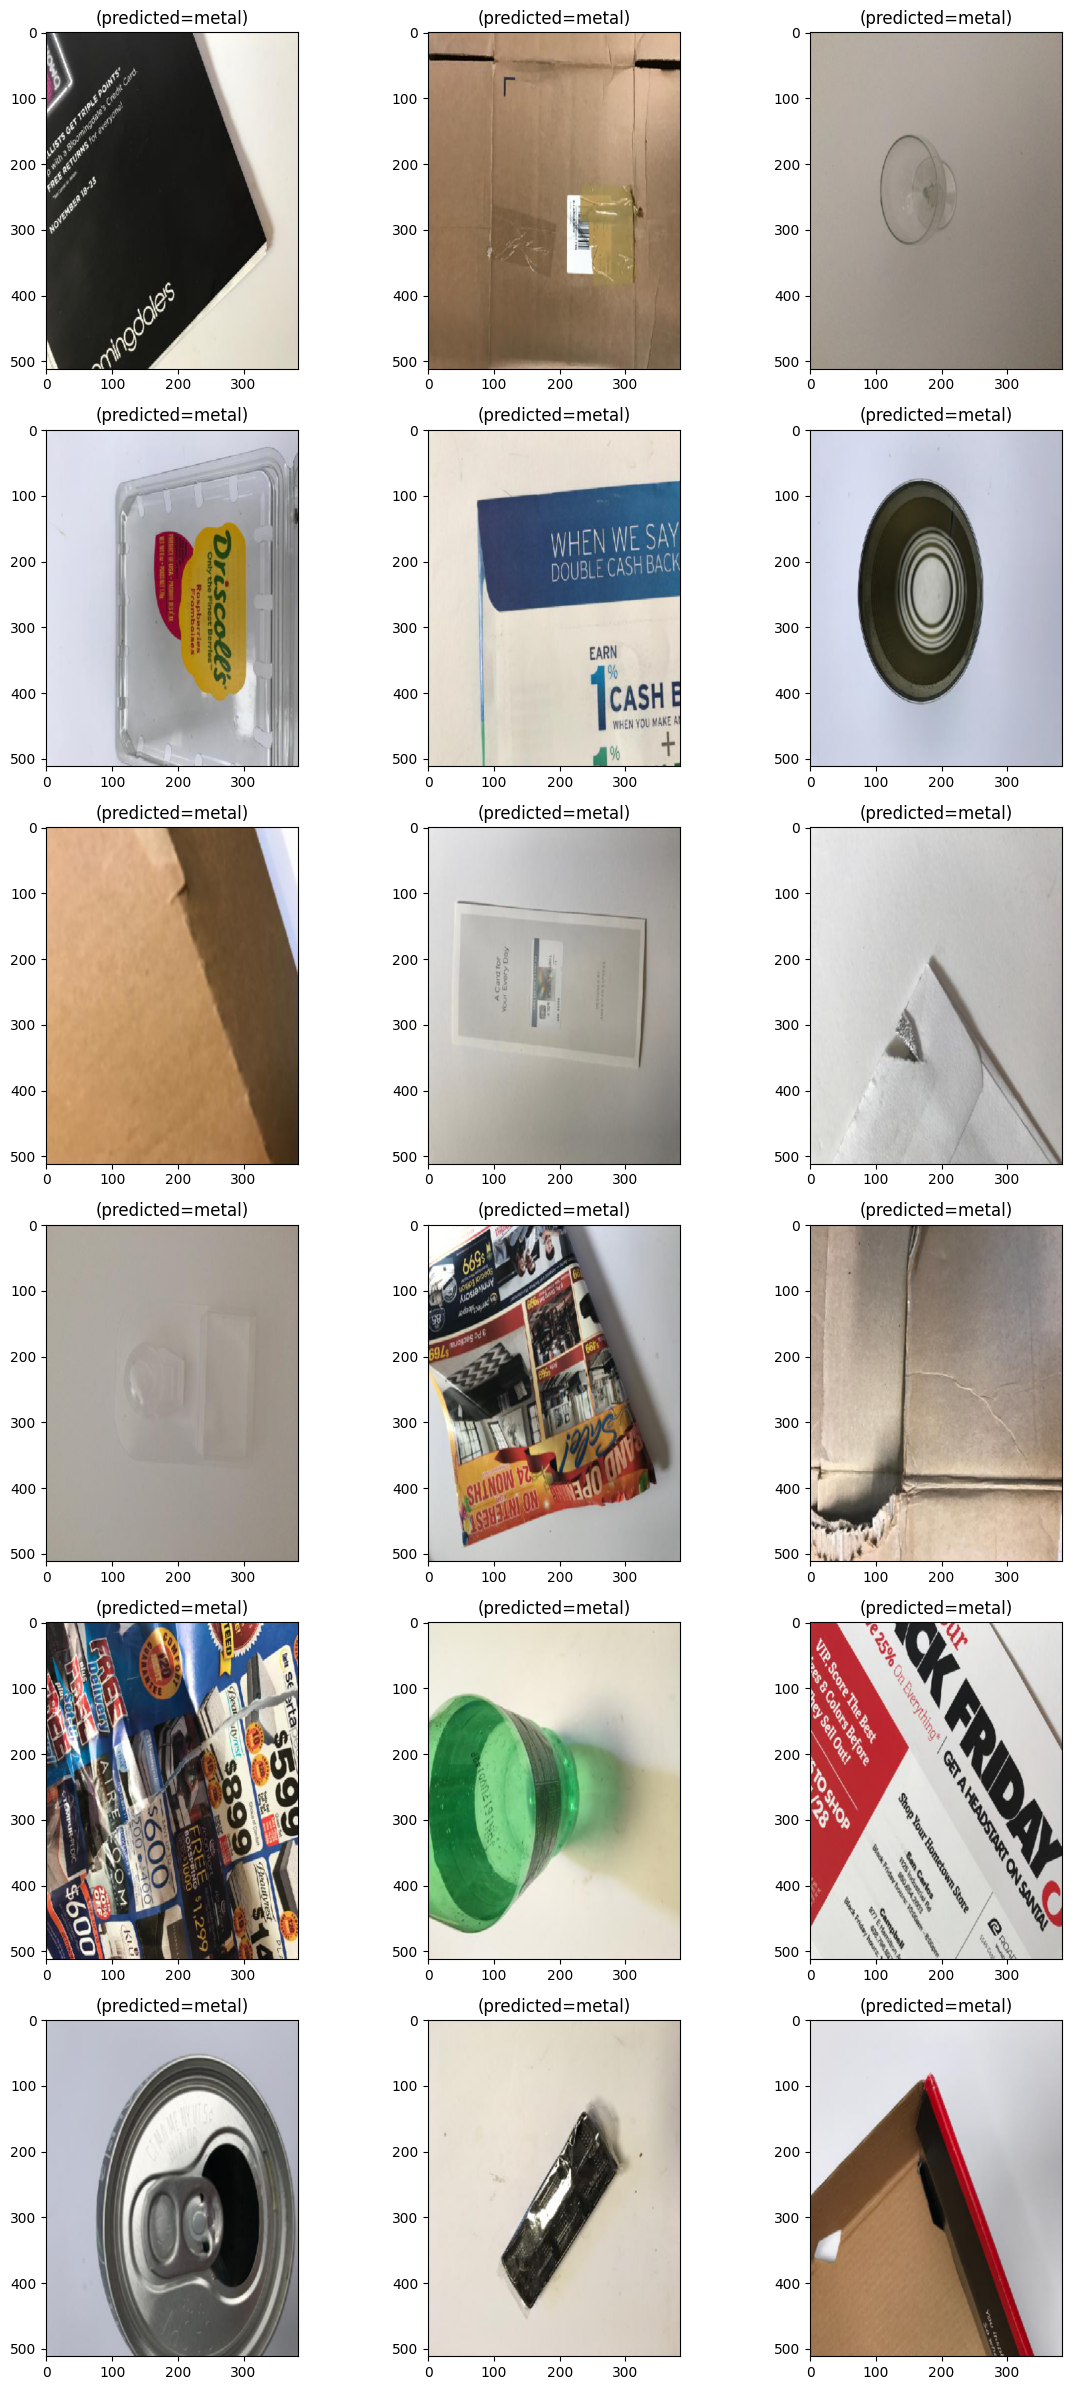

In [26]:
import matplotlib.pyplot as plt 
import matplotlib

sample_test = test_df.sample(n=18)
plt.figure(figsize=(12, 24))

i=1
for index, row in sample_test.iterrows():
    if i <= 18:
        filename = row['filename']
        category = row['pred_category']
        img = load_img(filename, target_size=IMAGE_SIZE)
        plt.subplot(6, 3, i)
        plt.imshow(img)
        plt.title('(predicted=' + "{}".format(category) + ')')
        i+=1
plt.tight_layout()

plt.show()



In [ ]:
submission_df = test_df.copy()
submission_df.to_csv('./submission.csv', index=False)
test_df.head(30)


Found 1 validated image filenames belonging to 1 classes.


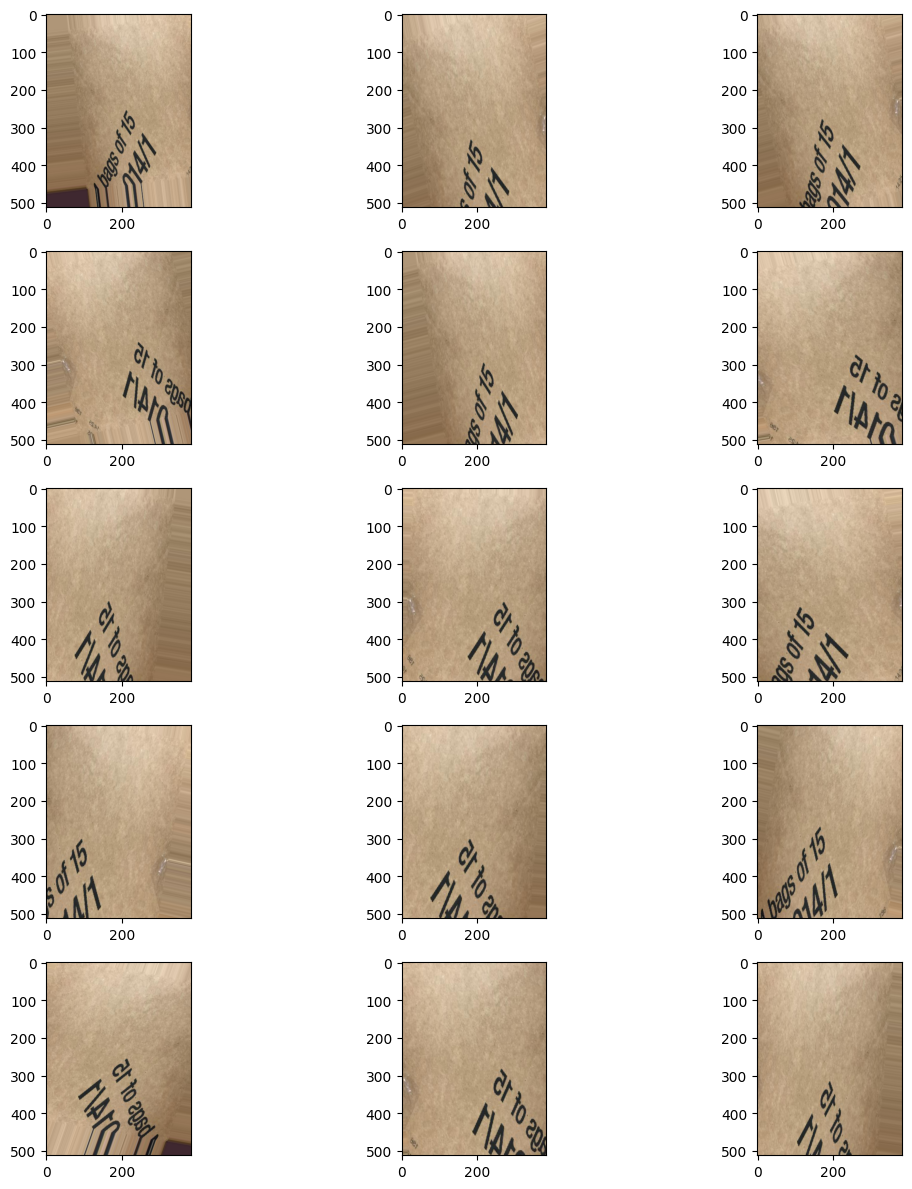

filename   category
0  ../Tensorflow/UnSortedWaste/cardboard92.jpg  cardboard

In [67]:
example_df = df_train.sample(n=1).reset_index(drop=True)
# Pull the image from directory
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

# Plot the effect of the data augmentation
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

example_df